In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
file_path = '/Users/celestetranbahuy/Desktop/AppliedMath/PseudoData.csv'
data = pd.read_csv(file_path, parse_dates=["call_datetime"])

# Number of days to forecast
n_forecast = 7

# Pre-process data
data['call_date'] = data['call_datetime'].dt.date               # Extract date (day)
daily_calls = data.groupby('call_date').size()                  # Count number of call per day
daily_calls.index = pd.to_datetime(daily_calls.index)           # Index with datetime

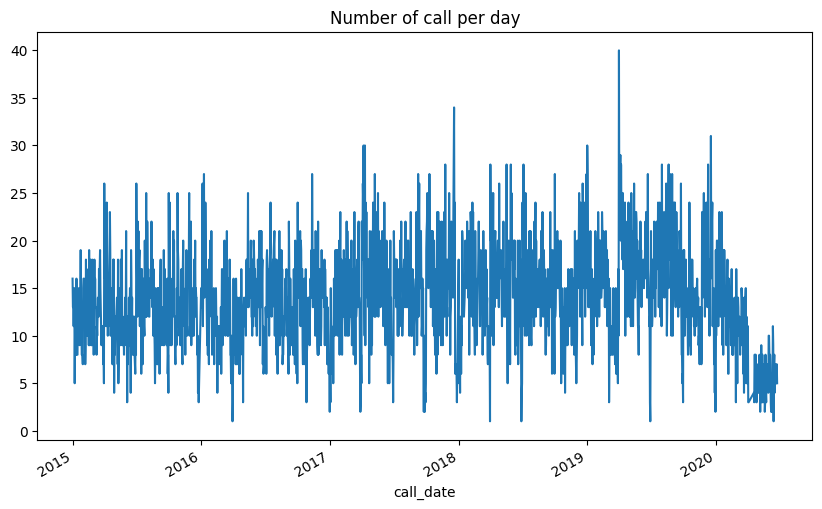

In [ ]:
## SLIDE 14 - visualize the data (run time <1s)

# Visualize daily calls
daily_calls.plot(title='Number of call per day', figsize=(10, 6))
plt.show()

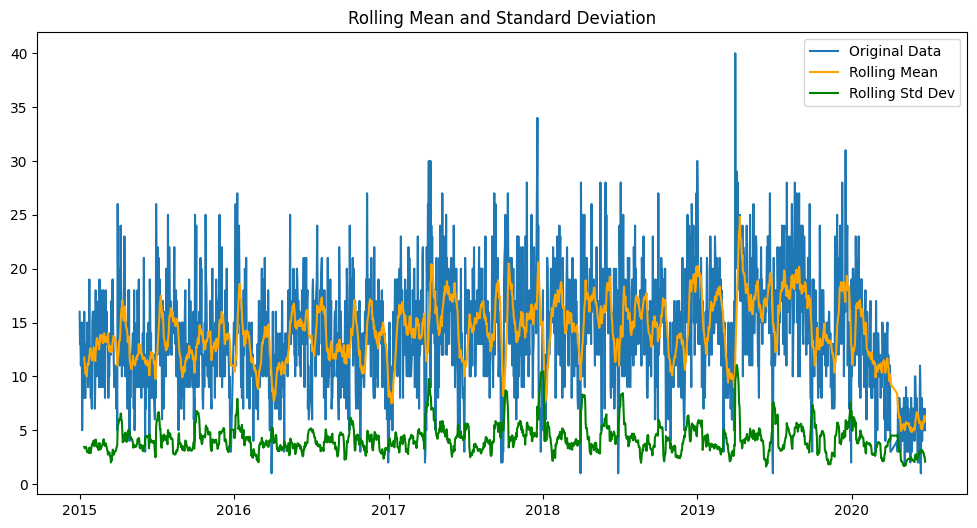

In [ ]:
## SLIDE 17 - check data stationary d = 1 (run time <1s)

from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Function to perform ADF test and visualize rolling statistics
def check_stationarity(time_series):
    # Rolling statistics
    rolling_mean = time_series.rolling(window=12).mean()
    rolling_std = time_series.rolling(window=12).std()

    # Plot original series and rolling statistics
    plt.figure(figsize=(12, 6))
    plt.plot(time_series, label='Original Data')
    plt.plot(rolling_mean, label='Rolling Mean', color='orange')
    plt.plot(rolling_std, label='Rolling Std Dev', color='green')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

# Apply function to your data
check_stationarity(daily_calls)

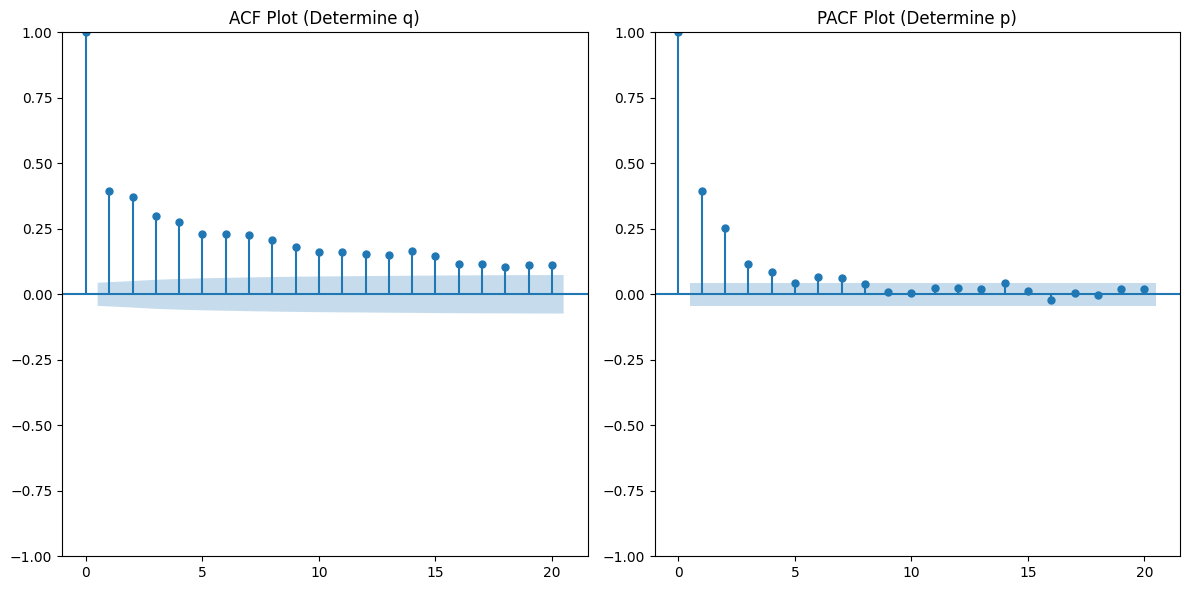

In [6]:
## SLIDE 18 - find parameters p and q (run time <1s)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plt.figure(figsize=(12, 6))

# ACF (for q)
plt.subplot(121)
plot_acf(daily_calls, lags=20, ax=plt.gca())
plt.title('ACF Plot (Determine q)')

# PACF (for p)
plt.subplot(122)
plot_pacf(daily_calls, lags=20, ax=plt.gca())
plt.title('PACF Plot (Determine p)')

plt.tight_layout()
plt.show()


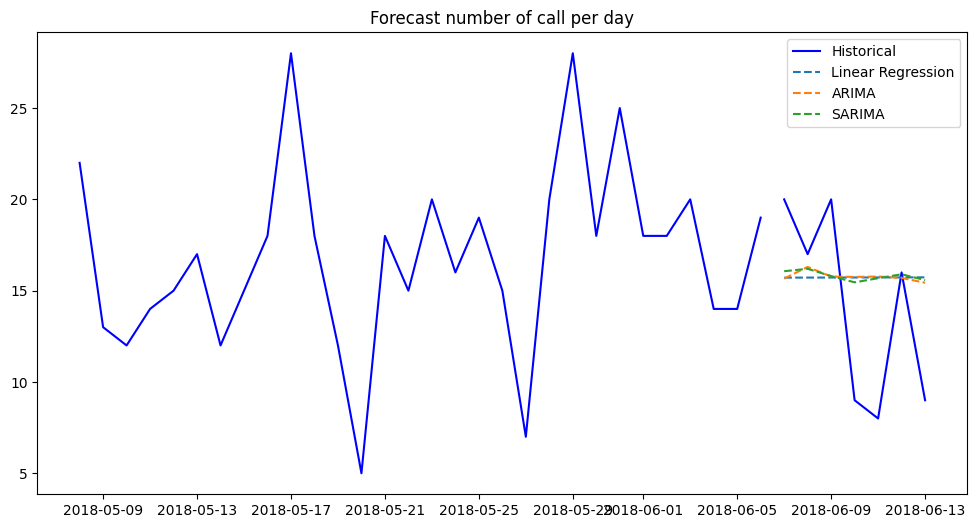

In [ ]:
## SLIDE 19 - visualize the forcast (run time <1s)

# Train and Test sets
window_size = 7 # number of days to forecast each time
train_size = len(daily_calls) - 730  # Use all data except two last years for cross validation
step_size = 7 # for cross validation

# Cross Validation
for start in range(train_size, len(daily_calls) - window_size, step_size):
    
    # Define train and test sets
    train = daily_calls[:start]
    test = daily_calls[start : start + window_size]

    # Linear Regression
    train_df = train.reset_index()
    train_df.columns = ['date', 'calls']
    train_df['days'] = (train_df['date'] - train_df['date'].min()).dt.days

    X_train = train_df[['days']]
    y_train = train_df['calls']
    model_lr = LinearRegression().fit(X_train, y_train)

    test_days = (test.index - train_df['date'].min()).days
    predictions_lr = model_lr.predict(test_days.values.reshape(-1, 1))

    # ARIMA
    model_arima = ARIMA(train, order=(6, 1, 4))  # Example orders (5, 1, 0)
    arima_fit = model_arima.fit()
    predictions_arima = arima_fit.forecast(steps=window_size)

    # SARIMA
    model_sarima = ARIMA(train, order=(6, 1, 4), seasonal_order=(1, 0, 1, 7))  # weekly seasonnality TBD
    sarima_fit = model_sarima.fit()
    predictions_sarima = sarima_fit.forecast(steps=window_size)

    
    # Plot only first batch of the Cross Validation to check
    if start == train_size:
        forecast_dates = pd.date_range(start=test.index[0], end=test.index[-1])
        plt.figure(figsize=(12, 6))
        plt.plot(train[-30:], label='Historical', c="b")
        plt.plot(test, c="b")
        plt.plot(forecast_dates, predictions_lr, label='Linear Regression', linestyle='--')
        plt.plot(forecast_dates, predictions_arima, label='ARIMA', linestyle='--')
        plt.plot(forecast_dates, predictions_sarima, label='SARIMA', linestyle='--')
        plt.title('Forecast number of call per day')
        plt.legend()
        plt.show()
